In [1]:

%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
import os

if ".." not in sys.path:
    sys.path.append("..")

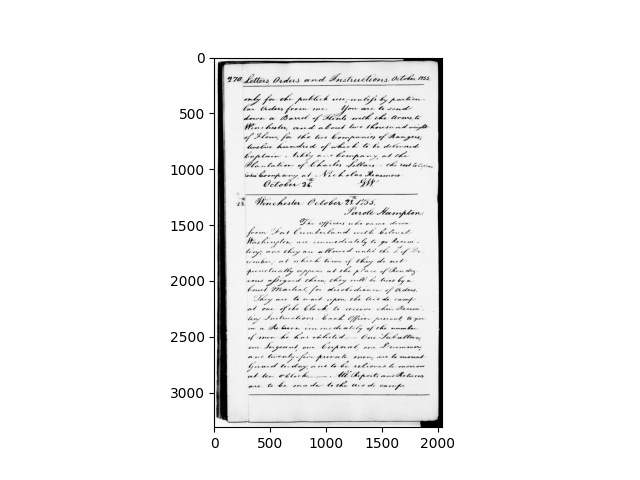

In [135]:
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

image = "2700270"
imagePath = f"./gw/pages/{image}.png"
gtPath = f"./gw/ground_truth/{image}.gtp"
hgtPath = f"./gw/heuristic_ground_truth/{image}.gtp"

imageFile = Image.open(imagePath)

# Für später folgende Verarbeitungsschritte muss das Bild mit float32-Werten vorliegen.
im_arr = np.asarray(imageFile)
doc_height , doc_width = im_arr.shape
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im_arr, cmap=cm.get_cmap('Greys_r'))


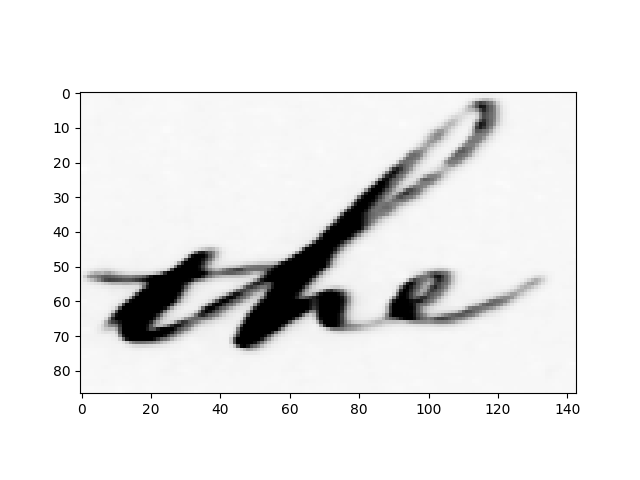

In [138]:
# load test image
labels = open(gtPath ,"r")
wordTheLine = labels.read().split("\n")[9].split(" ")
x1 , y1 , x2 , y2 = int(wordTheLine[0]) , int(wordTheLine[1]) , int(wordTheLine[2]) , int(wordTheLine[3])
testing_word_arr = im_arr[y1:y2, x1:x2]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(testing_word_arr, cmap=cm.get_cmap('Greys_r'))

In [140]:
# compute the features of the test image 
from scipy.cluster.vq import kmeans2
from common.features import compute_sift_descriptors

testing_word_frames ,testing_word_desc  = compute_sift_descriptors(testing_word_arr)
page_frames ,page_desc  = compute_sift_descriptors(im_arr)
n_centroids = 80 
# create a cluster of the full image
_, labels = kmeans2(page_desc, n_centroids, iter=20, minit='points')

<BarContainer object of 80 artists>

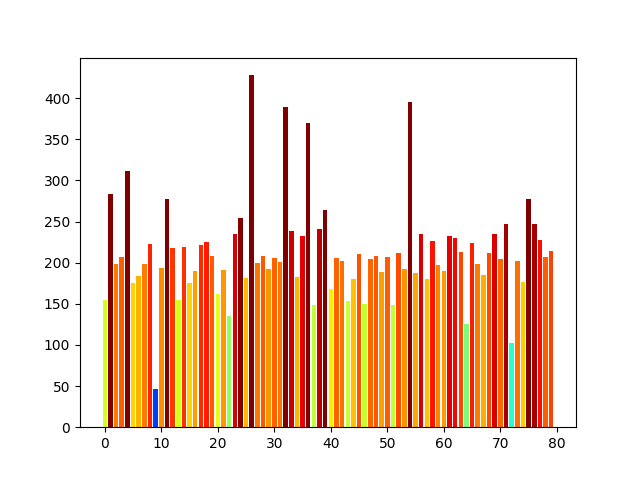

In [141]:
# compute the bag of features
bin_count = np.bincount(labels,minlength = n_centroids)
bin_count

fig = plt.figure()
ax = fig.add_subplot(111)
colormap = cm.get_cmap('jet')
ax.bar(list(range(n_centroids)) , bin_count , color = [colormap(bin) for bin in bin_count])

x1=580, x2=723, y1=319, y2=406
{11: 2, 38: 2, 41: 2, 21: 1, 8: 2, 62: 1, 32: 1, 20: 1, 6: 1, 54: 2, 26: 2, 55: 1, 12: 1, 36: 1, 4: 1, 2: 1, 58: 1, 15: 1, 49: 1, 34: 1, 24: 1, 67: 1}


<BarContainer object of 22 artists>

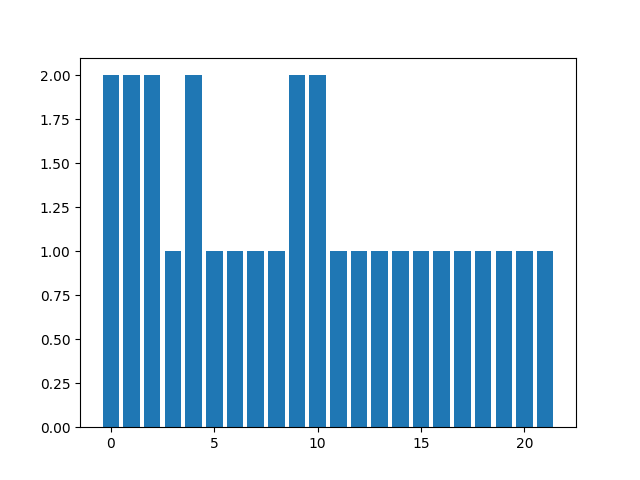

In [142]:
# takes a position of a grid in the image and uses the cluster of sift desc to calculate the bag of features histgramm
def get_bag_of_words_histogram(sift_descriptors , page_frames , labels , x1 , x2 , y1 , y2):
	# sift_descriptors: the sift descriptors of the full image
	# sift_descriptors_positions: the positions of the sift descriptors in the full image
	# sift_descriptors_labels_array: an array that contains a label for each sift descriptors
	# x1,x2,y1,y2: the positions of the frame

	# the function works as follows:
		# go over all descriptors inside the frame
		# for each one of them get its label
		# increment a counter for each label
		# return the histogram
		# the histogram is a map of this form {'label' : count} e.g {'f1' : 4} means that the label f1 is coming 4 times inside the frame
	assert sift_descriptors.shape[0] == len(page_frames) and len(page_frames) == labels.shape[0] , "wrong vars"
	print(f"x1={x1}, x2={x2}, y1={y1}, y2={y2}")

	label_to_count = {}
	for desc , frame , label in zip(sift_descriptors , page_frames , labels):
		if frame[1] < x1 or frame[1] > x2 or frame[0] < y1 or frame[0]  > y2:
			continue
		label_to_count[label] = label_to_count.get(label , 0) + 1
	return label_to_count


# # bag of features histogram for the request image
request_image_histogram = get_bag_of_words_histogram(page_desc , page_frames , labels , x1 , x2 , y1 , y2)

print(request_image_histogram)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(request_image_histogram)), list(request_image_histogram.values()), align='center')


In [156]:

# # bag of features histograms for the frames 
frame_width = x2 - x1
frame_height = y2 - y1
step_size_x = frame_width // 2
step_size_y = frame_height // 2
frame_x1 = 0
frame_y1 = 0
frame_x2 = frame_x1 + frame_width
frame_y2 = frame_y1 + frame_height
print(step_size_x)

71


In [144]:

window_histograms = [] # array of dicts {"window" : [x1,y1,x2,y2] , "histogram" : ...}

while True:
	print("compute histogram for window x1,y1,x2,y2" ,frame_x1 , frame_y1 , frame_x2 , frame_y2 )
	# do operation on the wi3ndow
	window_histogram = get_bag_of_words_histogram(page_desc , page_frames , labels , frame_x1 , frame_x2 , frame_y1 , frame_y2)
	window_histograms.append({"window" : [frame_x1 , frame_y1 , frame_x2 , frame_y2] , "histogram" : window_histogram})

	# update the window to the left
	frame_x1 += step_size_x
	frame_x2 = frame_x1 + frame_width

	# if we are at the end to the most far right. go down 
	if frame_x2 > doc_width: 
		frame_x1 = 0
		frame_x2 = frame_x1 + frame_width
		frame_y1 += step_size_y
		frame_y2 = frame_y1 + frame_height
	
	# if we are done. break
	if frame_y2 > doc_height:
		break


compute histogram for window x1,y1,x2,y2 0 0 143 87
x1=0, x2=143, y1=0, y2=87
compute histogram for window x1,y1,x2,y2 71 0 214 87
x1=71, x2=214, y1=0, y2=87
compute histogram for window x1,y1,x2,y2 142 0 285 87
x1=142, x2=285, y1=0, y2=87
compute histogram for window x1,y1,x2,y2 213 0 356 87
x1=213, x2=356, y1=0, y2=87
compute histogram for window x1,y1,x2,y2 284 0 427 87
x1=284, x2=427, y1=0, y2=87
compute histogram for window x1,y1,x2,y2 355 0 498 87
x1=355, x2=498, y1=0, y2=87
compute histogram for window x1,y1,x2,y2 426 0 569 87
x1=426, x2=569, y1=0, y2=87
compute histogram for window x1,y1,x2,y2 497 0 640 87
x1=497, x2=640, y1=0, y2=87
compute histogram for window x1,y1,x2,y2 568 0 711 87
x1=568, x2=711, y1=0, y2=87
compute histogram for window x1,y1,x2,y2 639 0 782 87
x1=639, x2=782, y1=0, y2=87
compute histogram for window x1,y1,x2,y2 710 0 853 87
x1=710, x2=853, y1=0, y2=87
compute histogram for window x1,y1,x2,y2 781 0 924 87
x1=781, x2=924, y1=0, y2=87
compute histogram for 

In [145]:
# compare for each window the difference in the two histograms
def compare_histograms(hist1 , hist2): 
	result = {}
	for i in range(n_centroids):
		label = i 
		labelCountFromHist1 = hist1.get(label , 0)
		labelCountFromHist2 = hist2.get(label , 0)
		result[label] = abs(labelCountFromHist1 - labelCountFromHist2)
	return result

window_histograms_after_comparing_with_request_image_histogram = []
for wh in window_histograms:
	window = wh['window']
	histogram = wh['histogram']
	compared_histogram =  compare_histograms(request_image_histogram , histogram)
	window_histograms_after_comparing_with_request_image_histogram.append({'window' : window , 'histogram' : compared_histogram , 'difference' : sum(compared_histogram.values()) })


In [146]:

# sort window_histograms_after_comparing_with_request_image_histogram based on the sum of all keys
window_histograms_after_comparing_with_request_image_histogram.sort(key= lambda item : item['difference'])


x1 497 x2 640
y1 301 y2 388
doc height 3311
doc width 2035


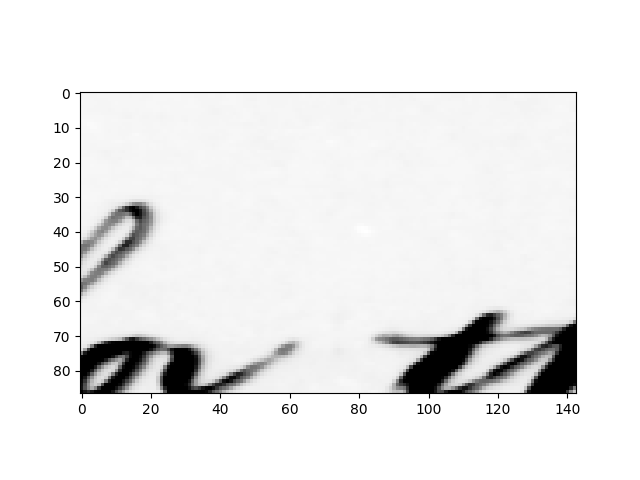

In [155]:
wx1,wy1,wx2,wy2 = window_histograms_after_comparing_with_request_image_histogram[2]['window']
print("x1" , wx1, "x2" , wx2)
print("y1" , wy1, "y2" , wy2)
print("doc height" , im_arr.shape[0])
print("doc width" , im_arr.shape[1])

testing_word_arr = im_arr[wy1:wy2, wx1:wx2]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(testing_word_arr , cmap=cm.get_cmap('Greys_r'))